In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [21]:
# 파일 불러오기
file_path = r"https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/diabetes.csv"
df = pd.read_csv(file_path)

In [22]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [23]:
# 특성과 레이블 분리
X = df.drop(columns='Outcome')  # 입력값
y = df['Outcome']               # 레이블 (0 또는 1)

In [24]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [25]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, 

((614, 8), (614,), (154, 8), (154,))

In [29]:
# 데이터를 pytorch에 맞게 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train= torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

In [30]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [31]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614, 1]),
 torch.Size([154, 1]))

In [ ]:
# 모델 정의
class DiabetesClassifier(nn.Module):
    def __init__(self):
        super(DiabetesClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()  # 이진 분류니까 sigmoid
        )

    def forward(self, x):
        return self.model(x)

model = DiabetesClassifier()

In [33]:
criterion = nn.BCELoss()  # Binary Classification Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [39]:
epochs = 200
losses = []
accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        predicted = (outputs >= 0.5).float()
        correct += (predicted == yb).sum().item()
        total += yb.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    losses.append(avg_loss)
    accuracies.append(accuracy)

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch 20/200, Loss: 0.1714, Accuracy: 0.9397
Epoch 40/200, Loss: 0.1504, Accuracy: 0.9560
Epoch 60/200, Loss: 0.1466, Accuracy: 0.9560
Epoch 80/200, Loss: 0.1414, Accuracy: 0.9625
Epoch 100/200, Loss: 0.1282, Accuracy: 0.9674
Epoch 120/200, Loss: 0.1242, Accuracy: 0.9707
Epoch 140/200, Loss: 0.1184, Accuracy: 0.9772
Epoch 160/200, Loss: 0.1114, Accuracy: 0.9821
Epoch 180/200, Loss: 0.1041, Accuracy: 0.9821
Epoch 200/200, Loss: 0.0941, Accuracy: 0.9821


In [40]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_class = (y_pred >= 0.5).float()


Test Accuracy: 0.6948


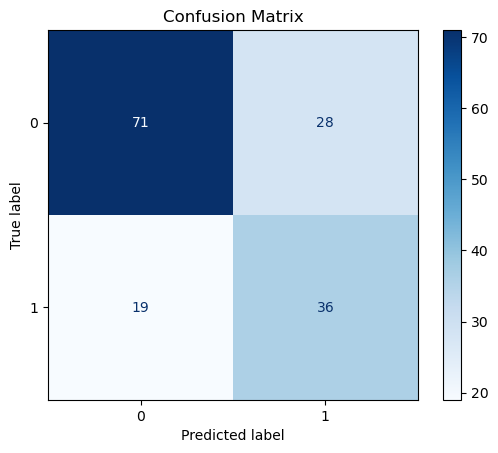

In [44]:
acc = accuracy_score(y_test, y_pred_class)
print(f"\nTest Accuracy: {acc:.4f}")

cm = confusion_matrix(y_test, y_pred_class)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

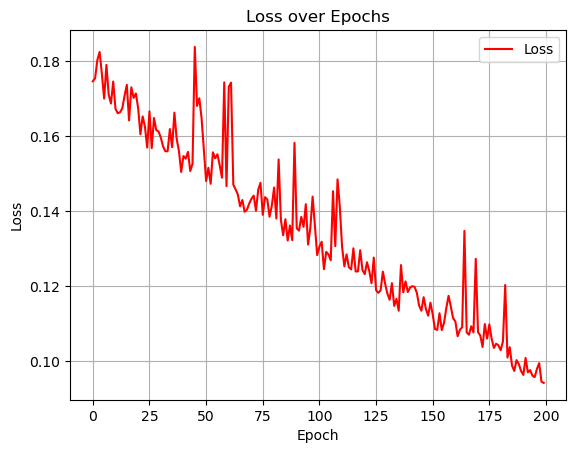

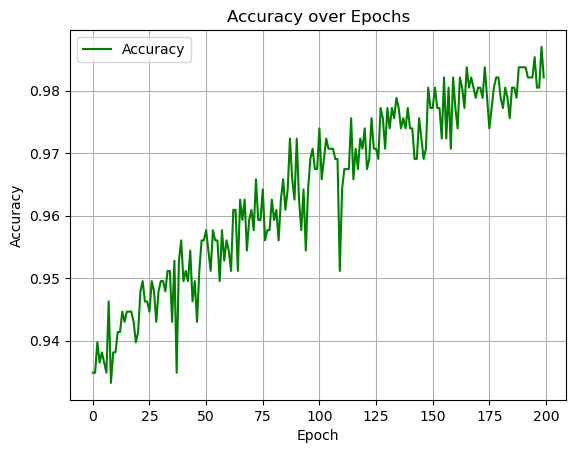

In [46]:
# Loss 시각화
plt.figure()
plt.plot(losses, label='Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.grid(True)
plt.legend()
plt.show()

# Accuracy 시각화
plt.figure()
plt.plot(accuracies, label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.grid(True)
plt.legend()
plt.show()
